In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
import time


pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

height has been deprecated.



In [37]:
df = pd.read_csv('files/NEWER_Clean_df.csv', index_col = 0)

In [38]:
channels                  1 non-null int64
delivery_method           1 non-null float64
show_map                  1 non-null int64
user_type                 1 non-null int64
has_logo                  1 non-null int64
org_facebook              1 non-null float64
sale_duration             1 non-null float64
sale_duration2            1 non-null int64
event_created_to_end      1 non-null int64
num_ticket_type           1 non-null int64
median_ticket_cost        1 non-null float64
total_tickets_sold        1 non-null int64
nan_delivery_method       1 non-null bool
nan_org_facebook          1 non-null bool
nan_num_ticket_type       1 non-null bool
nan_median_ticket_cost    1 non-null bool

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13661 entries, 0 to 14336
Data columns (total 19 columns):
label                     13661 non-null int64
channels                  13661 non-null int64
delivery_method           13661 non-null float64
show_map                  13661 non-null int64
user_type                 13661 non-null int64
has_logo                  13661 non-null int64
org_facebook              13661 non-null float64
sale_duration             13661 non-null float64
sale_duration2            13661 non-null int64
event_created_to_end      13661 non-null int64
num_ticket_type           13661 non-null float64
median_ticket_cost        13661 non-null float64
total_tickets_sold        13661 non-null int64
nan_delivery_method       13661 non-null bool
nan_org_facebook          13661 non-null bool
nan_num_ticket_type       13661 non-null bool
nan_median_ticket_cost    13661 non-null bool
payout_type_CHECK         13661 non-null int64
payout_type_MISSING       13661 non-nul

In [39]:
df.head()

,label,channels,delivery_method,show_map,user_type,has_logo,org_facebook,sale_duration,sale_duration2,event_created_to_end,num_ticket_type,median_ticket_cost,total_tickets_sold,nan_delivery_method,nan_org_facebook,nan_num_ticket_type,nan_median_ticket_cost,payout_type_CHECK,payout_type_MISSING
0,1,5,0.0,1,1,0,0.0,29.0,33,33,3.0,50.00,0,False,False,False,False,0,1
1,0,0,1.0,0,3,1,0.0,28.0,28,28,2.0,35.00,25,False,False,False,False,1,0
2,0,8,1.0,0,3,0,0.0,54.0,54,54,1.0,93.51,48,False,False,False,False,1,0
3,0,6,1.0,0,3,1,0.0,0.0,0,322,6.0,13.50,58,False,False,False,False,0,0
4,0,11,0.0,0,3,0,0.0,63.0,63,63,8.0,92.50,39,False,False,False,False,1,0


In [5]:
y = df.pop('label').values

In [6]:
X = df.values

In [7]:
df.shape

(13661, 18)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## XgBoost

In [10]:

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [11]:
model.score(X_test, y_test)

0.98444647758462944

In [29]:
def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9844
AUC Score (Train): 0.988595


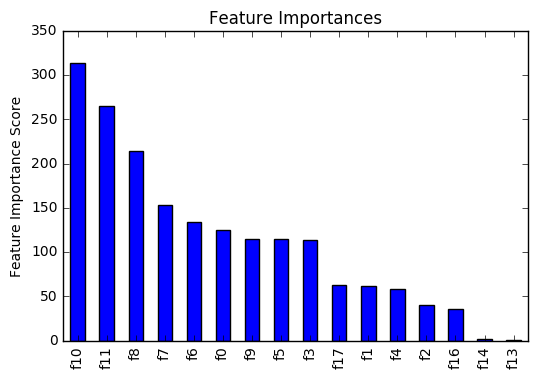

In [30]:
predictors = [x for x in df.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
modelfit(xgb1, X_train, y_train, X_test, y_test)

In [34]:
param_test1 = {
 'max_depth':range(5,7),
 'min_child_weight':range(1,3),
 'learning_rate': [.05, .1, .2],
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.98967, std: 0.00277, params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1},
  mean: 0.98953, std: 0.00256, params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2},
  mean: 0.99021, std: 0.00274, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1},
  mean: 0.98969, std: 0.00252, params: {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2},
  mean: 0.98992, std: 0.00313, params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1},
  mean: 0.98920, std: 0.00314, params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2},
  mean: 0.98965, std: 0.00368, params: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1},
  mean: 0.98969, std: 0.00281, params: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2},
  mean: 0.99036, std: 0.00373, params: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1},
  mean: 0.98818, std: 0.00272, params: {'learning_rate': 0.2, 'max_depth': 5, 

In [35]:
from sklearn.externals import joblib
joblib.dump(gsearch1, 'zack_xgboost.pkl')


['zack_xgboost.pkl']

In [12]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=df.shape[1], activation='relu'))
    model.add(Dense(df.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# load pima indians dataset
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=100)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, X, y.ravel(), cv=kfold)
print(results.mean())

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E